In [218]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Loading results dataframes for use in linear regression modeling
run_data = pd.read_csv("data/stream-data/raw-stream-data/russian.csv", thousands=',')
days_below_32 = pd.read_csv("data/weather-data/KenaiAirport_Days-Below-32F.csv")
summer_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Summer-Mean-Temps-Yearly.csv")
winter_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Winter-Mean-Temps-Yearly.csv")
# merge the temperature data into a single dataframe
input_data = pd.merge(left=days_below_32, right=summer_mean_temps, left_on='year', right_on='year')
input_data = pd.merge(left=input_data, right=winter_mean_temps, left_on='year', right_on='year')
# adding missing years and imputing their values at the mean
missing_days = pd.DataFrame({
    'year' : [1970, 1971, 1972],
    'days_below_32' : [None, None, None],
    'mean_summer_temp' : [None, None, None],
    'mean_winter_temp' : [None, None, None]
})
input_data = pd.concat([input_data, missing_days])
imputer = SimpleImputer(strategy='mean')
x_vals = imputer.fit_transform(input_data)
input_data = pd.DataFrame(x_vals, columns=input_data.columns)
# sorting the data by year for readability/plotting purposes
input_data.sort_values(by=['year'], inplace=True, ignore_index=True)

Now that we have our data loaded and the proper modules imported, let's process the Russian
River run datafile to parse out our target output variables (run counts) as well as gather a 
few more potential input variables (effort counts or "angler days").

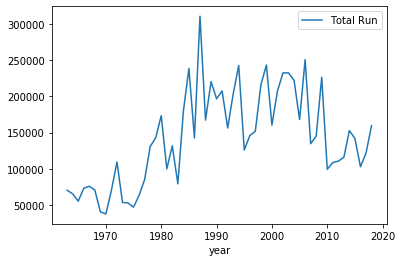

In [219]:
drop_columns = ['ER  Escapement', 'LR Escapement', 'ER', 'LR']
run_data.drop(columns=drop_columns, inplace=True)
run_data.rename(columns={'Year' : 'year'}, inplace=True)
# merge with the input_data frame
model_data = pd.merge(left=input_data, right=run_data, left_on='year', right_on='year')
# dropping the year with no Effort value
model_data.drop(index=0, inplace=True)
model_data['Effort'] = model_data['Effort'].str.replace(',', '').astype(int)
# plotting total run per year to see how the data trends by itself
model_data.plot(x='year', y='Total Run')

Now we need to timelag the Effort column for 3 years prior (average life of salmon before returning).
This allows the effort values of prior years to be used as a predictor for future runs.

In [220]:
def get_effort_3_years_ago(row):
    target_year = row.year - 3
    try:
        return model_data[model_data['year'] == target_year].iloc[0]['Effort']
    except:
        return None

temp_data = model_data.drop(index=[1,2,3])
temp_data['effort_3_years_ago'] = temp_data.apply(get_effort_3_years_ago, axis=1)
model_data = temp_data
    

Let's take a look at the correlations between our dataset to see if we can identify any
potential collinearity that will allow us to simply our input complexity.

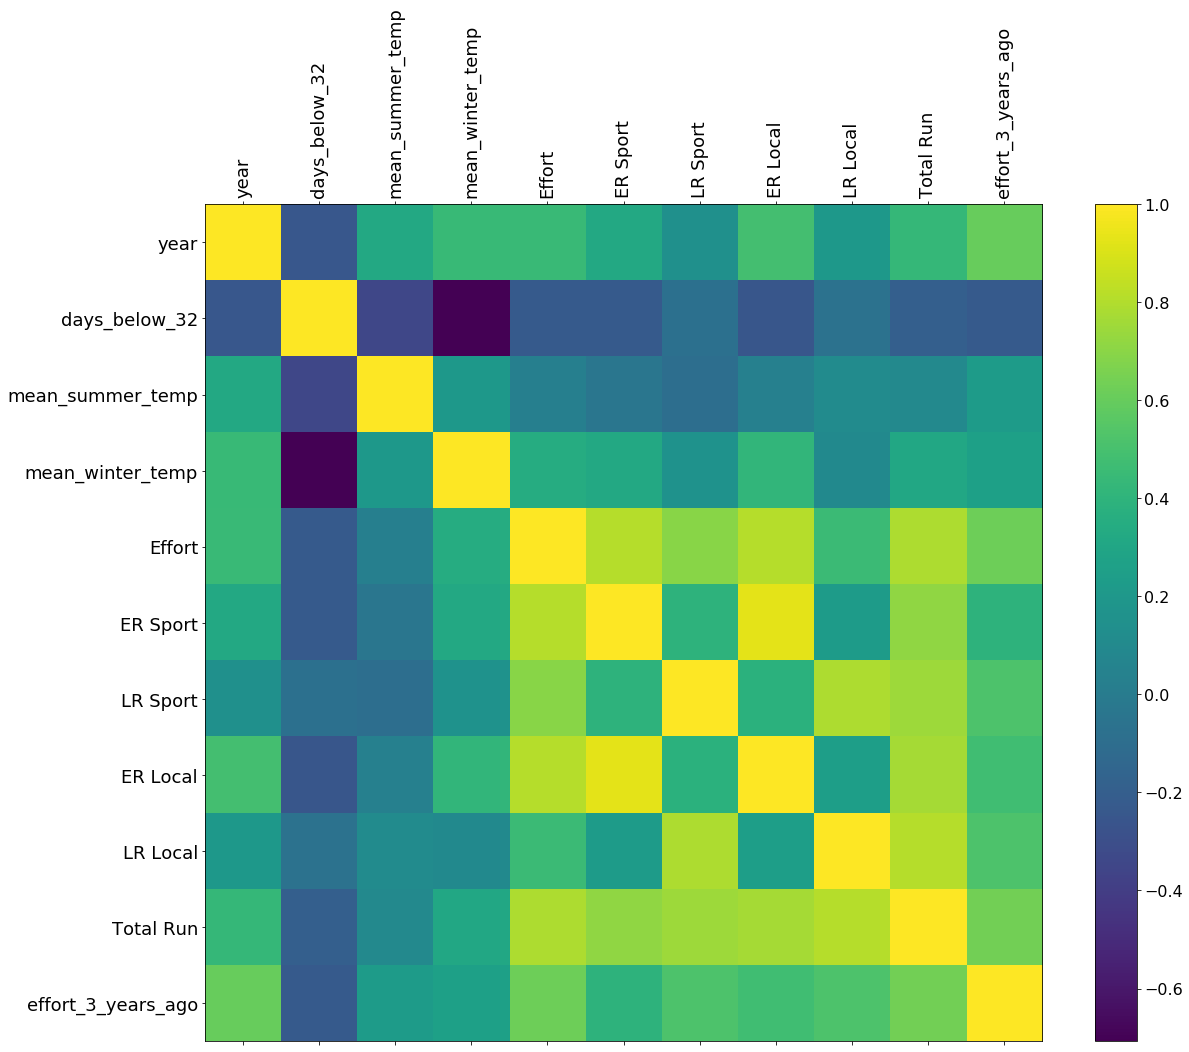

In [221]:
matrix = model_data.corr()
correlations = plt.figure(figsize=(19,15))
plt.matshow(matrix, fignum=correlations.number)
plt.xticks(range(model_data.shape[1]), model_data.columns, rotation=90, fontsize=18)
plt.yticks(range(model_data.shape[1]), model_data.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)

Now it's time to try and train the model using basic linear regression as well as Lasso and Ridge
regression techniques to see how capable our data is at predicting run counts.